In [1]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, BatchNormalization, Flatten, Reshape
from tensorflow.keras.layers import LSTM, Dense, Dropout, Concatenate
from tensorflow.keras.utils import plot_model,to_categorical
from tensorflow.keras.optimizers import Adam

import pandas as pd
import librosa as lb
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sn

In [2]:
# Arbitrary (For now)
mfcc_input_shape = (40, 679)  # raw MFCC shape (69, 420)
chroma_input_shape = (12, 259)  # raw Chroma shape (69, 420)

# ========== MFCC BRANCH ==========
mfcc_input = Input(shape=mfcc_input_shape, name='mfcc_input')

# Reshape for CNN
mfcc_reshaped = Reshape((mfcc_input_shape[0], mfcc_input_shape[1], 1))(mfcc_input)  # (69, 420, 1)

# CNN Path
mfcc_cnn = Conv2D(32, (3,3), activation='relu', padding='same')(mfcc_reshaped)
mfcc_cnn = BatchNormalization()(mfcc_cnn)
mfcc_cnn = MaxPooling2D(pool_size=(2,2))(mfcc_cnn)

mfcc_cnn = Conv2D(64, (3,3), activation='relu', padding='same')(mfcc_cnn)
mfcc_cnn = BatchNormalization()(mfcc_cnn)
mfcc_cnn = MaxPooling2D(pool_size=(2,2))(mfcc_cnn)

mfcc_cnn = Conv2D(128, (3,3), activation='relu', padding='same')(mfcc_cnn)
mfcc_cnn = BatchNormalization()(mfcc_cnn)
mfcc_cnn = MaxPooling2D(pool_size=(2,2))(mfcc_cnn)

mfcc_cnn_flat = Flatten()(mfcc_cnn)

# LSTM Path
mfcc_lstm_input = Reshape((mfcc_input_shape[1], mfcc_input_shape[0]))(mfcc_input)  # (420, 69)
mfcc_lstm = LSTM(512, return_sequences=True)(mfcc_lstm_input)
mfcc_lstm = LSTM(256, return_sequences=True)(mfcc_lstm)
mfcc_lstm = LSTM(128)(mfcc_lstm)

# Fuse CNN + LSTM (MFCC branch)
mfcc_fused = Concatenate()([mfcc_cnn_flat, mfcc_lstm])

# ========== CHROMA BRANCH ==========
chroma_input = Input(shape=chroma_input_shape, name='chroma_input')

# Reshape for CNN
chroma_reshaped = Reshape((chroma_input_shape[0], chroma_input_shape[1], 1))(chroma_input)  # (69, 420, 1)

# CNN Path
chroma_cnn = Conv2D(32, (3,3), activation='relu', padding='same')(chroma_reshaped)
chroma_cnn = BatchNormalization()(chroma_cnn)
chroma_cnn = MaxPooling2D(pool_size=(2,2))(chroma_cnn)

chroma_cnn = Conv2D(64, (3,3), activation='relu', padding='same')(chroma_cnn)
chroma_cnn = BatchNormalization()(chroma_cnn)
chroma_cnn = MaxPooling2D(pool_size=(2,2))(chroma_cnn)

chroma_cnn = Conv2D(128, (3,3), activation='relu', padding='same')(chroma_cnn)
chroma_cnn = BatchNormalization()(chroma_cnn)
chroma_cnn = MaxPooling2D(pool_size=(2,2))(chroma_cnn)

chroma_cnn_flat = Flatten()(chroma_cnn)

# LSTM Path
chroma_lstm_input = Reshape((chroma_input_shape[1], chroma_input_shape[0]))(chroma_input)  # (420, 69)
chroma_lstm = LSTM(512, return_sequences=True)(chroma_lstm_input)
chroma_lstm = LSTM(256, return_sequences=True)(chroma_lstm)
chroma_lstm = LSTM(128)(chroma_lstm)

# Fuse CNN + LSTM (Chroma branch)
chroma_fused = Concatenate()([chroma_cnn_flat, chroma_lstm])

# ========== FINAL FUSION & OUTPUT ==========
final_fusion = Concatenate()([mfcc_fused, chroma_fused])
dense = Dense(384, activation='relu')(final_fusion)
dropout = Dropout(0.4)(dense)
# use 8 if LRTI and Asthma is not dropped
output = Dense(8, activation='softmax')(dropout)
#output = Dense(6, activation='softmax')(dropout)
learning_rate = 0.0001 

# Model
model = Model(inputs=[mfcc_input, chroma_input], outputs=output)
model.compile(optimizer=Adam(learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ mfcc_input (InputLayer)       │ (None, 40, 679)           │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ chroma_input (InputLayer)     │ (None, 12, 259)           │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ reshape (Reshape)             │ (None, 40, 679, 1)        │               0 │ mfcc_input[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ reshape_2 (Reshape)           │ (None, 12, 259, 1)        │               0 │ chroma_input[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d (Conv2D)               │ (None, 40, 679, 32)       │             320 │ reshape[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_3 (Conv2D)             │ (None, 12, 259, 32)       │             320 │ reshape_2[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization           │ (None, 40, 679, 32)       │             128 │ conv2d[0][0]               │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_3         │ (None, 12, 259, 32)       │             128 │ conv2d_3[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d (MaxPooling2D)  │ (None, 20, 339, 32)       │               0 │ batch_normalization[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_3               │ (None, 6, 129, 32)        │               0 │ batch_normalization_3[0][… │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_1 (Conv2D)             │ (None, 20, 339, 64)       │          18,496 │ max_pooling2d[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_4 (Conv2D)             │ (None, 6, 129, 64)        │          18,496 │ max_pooling2d_3[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_1         │ (None, 20, 339, 64)       │             256 │ conv2d_1[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_4         │ (None, 6, 129, 64)        │             256 │ conv2d_4[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_1               │ (None, 10, 169, 64)       │               

 Total params: 26,682,504 (101.79 MB)

 Trainable params: 26,681,608 (101.78 MB)

 Non-trainable params: 896 (3.50 KB)

In [3]:
# Automations
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import TensorBoard
import datetime

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

checkpoint = ModelCheckpoint('best_model_4A.keras', monitor='val_accuracy',
                             save_best_only=True, mode='max', verbose=1)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=5, min_lr=1e-6, verbose=1)

log_dir = f"logs/fit/{datetime.datetime.now().strftime('%Y%m%d-%H%M%S')}"
tensorboard = TensorBoard(log_dir=log_dir, histogram_freq=1)


In [4]:
df = pd.read_csv('D:/last-se7en/4A/augmented.csv')
df = df.drop('Unnamed: 0', axis='columns')
df.head()

,pid,filename,disease
0,136,136_1b1_Ar_sc_Meditron_2.wav-1,Healthy
1,136,136_1b1_Ar_sc_Meditron_2.wav-2,Healthy
2,102,102_1b1_Ar_sc_Meditron_6.wav-1,Healthy
3,102,102_1b1_Ar_sc_Meditron_6.wav-2,Healthy
4,127,127_1b1_Ar_sc_Meditron_0.wav-1,Healthy


In [ ]:
df = df.drop({'Age', 'Sex', 'BMI', 'Side', 'Weezels', 'Crackles', 'pid'}, axis='columns')
df.head()

In [ ]:
# Run this if you want to drop LRTI and asthma
#df = df[~df['Diagnosis'].isin(['Asthma', 'LRTI'])].reset_index(drop=True)

In [5]:
def get_waveforms(path, sr):
    file, _ = lb.load("D:/last-se7en/4A/augmented/" + path, sr=sr)
    return file

In [6]:
waveforms = []

for index, row in df.iterrows():
  waveforms.append(get_waveforms(row.filename, 22050))


In [7]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
chroma = []
mfcc = []
sample_rate = 22050
for waveform in waveforms:
  stft = np.abs(lb.stft(waveform)) #Short-Time Fourier Transform. Needed for the chroma
  chroma_wave = lb.feature.chroma_stft(S=stft, sr=sample_rate, n_fft=4096, hop_length=512)
  mfcc_wave = lb.feature.mfcc(y=waveform, sr = sample_rate,  n_mfcc=40, n_fft=1024, hop_length=256, n_mels=128)

  mfcc_padded = pad_sequences(mfcc_wave, padding='post', dtype='float32', maxlen=679)
  chroma_padded = pad_sequences(chroma_wave, padding='post', dtype='float32', maxlen=259)

  chroma.append(np.array(chroma_padded))
  mfcc.append(np.array(mfcc_padded))


C:\Users\INSTRUCT-D522lab\AppData\Local\Programs\Python\Python311\Lib\site-packages\librosa\core\pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


In [8]:
#uncomment if ASTHMA and LRTI is dropped
to_hot_one = {"COPD":0, "Healthy":1, "URTI":2, "Bronchiectasis":3, "Pneumonia":4, "Bronchiolitis":5, "Asthma":6, "LRTI":7}
#to_hot_one = {"COPD":0, "Healthy":1, "URTI":2, "Bronchiectasis":3, "Pneumonia":4, "Bronchiolitis":5}
diagnosis = []
for _, row in df.iterrows():
  diagnosis.append(to_hot_one[row['disease']])

In [9]:
# First split: 90% train_val, 10% test
X_mfcc_train_val, X_mfcc_test, X_chroma_train_val, X_chroma_test, y_train_val, y_test = train_test_split(
    np.array(mfcc), np.array(chroma), diagnosis, test_size=0.10, random_state=10,  stratify=diagnosis
)

# Second split: from 90%, get 80% train, 20% val
X_mfcc_train, X_mfcc_val, X_chroma_train, X_chroma_val, y_train, y_val = train_test_split(
    X_mfcc_train_val, X_chroma_train_val, y_train_val, test_size=0.20, random_state=10, stratify=y_train_val
)

# One-hot encode all sets
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_test = to_categorical(y_test)



In [10]:
# Format new data
X_mfcc_train = X_mfcc_train.reshape((-1, 40, 679))
X_chroma_train =  X_chroma_train.reshape((-1, 12, 259))
X_mfcc_test = X_mfcc_test.reshape((-1, 40, 679))
X_chroma_test = X_chroma_test.reshape((-1, 12, 259))

Epoch 1/200
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.3210 - loss: 3.6383
Epoch 1: val_accuracy improved from -inf to 0.43615, saving model to best_model_4A.keras
115/115 ━━━━━━━━━━━━━━━━━━━━ 1109s 10s/step - accuracy: 0.3217 - loss: 3.6259 - val_accuracy: 0.4361 - val_loss: 1.6539 - learning_rate: 1.0000e-04
Epoch 2/200
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.5392 - loss: 1.2365
Epoch 2: val_accuracy improved from 0.43615 to 0.57760, saving model to best_model_4A.keras
115/115 ━━━━━━━━━━━━━━━━━━━━ 1062s 9s/step - accuracy: 0.5394 - loss: 1.2363 - val_accuracy: 0.5776 - val_loss: 1.3334 - learning_rate: 1.0000e-04
Epoch 3/200
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.6283 - loss: 1.0193
Epoch 3: val_accuracy improved from 0.57760 to 0.62672, saving model to best_model_4A.keras
115/115 ━━━━━━━━━━━━━━━━━━━━ 1066s 9s/step - accuracy: 0.6284 - loss: 1.0192 - val_accuracy: 0.6267 - val_loss: 1.0456 - learning_rate: 1.0000e-04
Epoch 4/200
115/115 ━━━━━━━

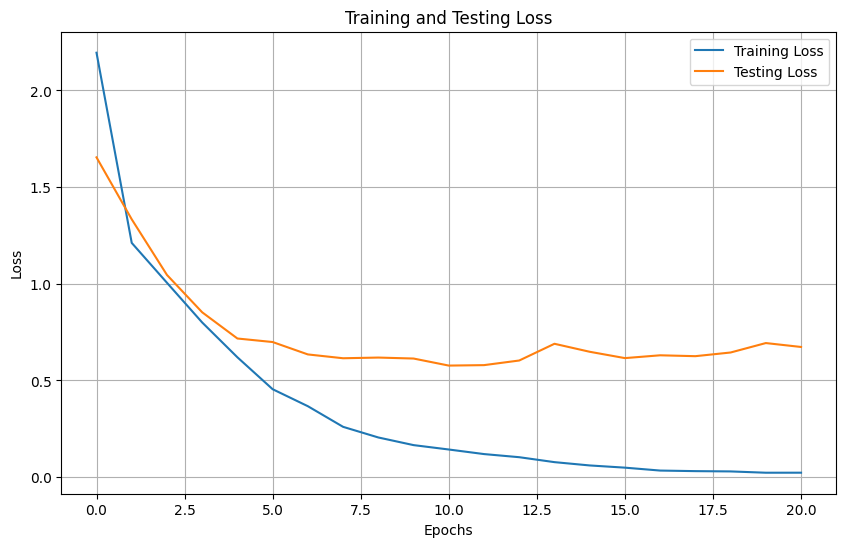

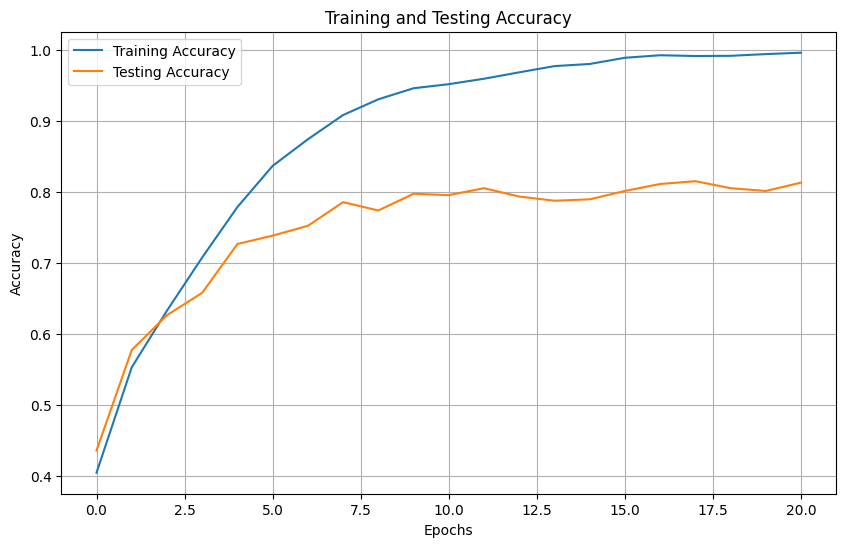

In [11]:
# After training the model, `history` contains the training and validation metrics
history = model.fit(
    [X_mfcc_train, X_chroma_train], y_train,
    validation_data=([X_mfcc_test, X_chroma_test], y_test),
    epochs=200,
    batch_size=32,
    callbacks=[early_stop, checkpoint, reduce_lr, tensorboard]
)

# Plotting Training and Validation Loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Testing Loss')

plt.title('Training and Testing Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plotting Training and Validation Accuracy
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Testing Accuracy')

plt.title('Training and Testing Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


16/16 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step
                precision    recall  f1-score   support

          COPD       0.94      0.94      0.94        63
       Healthy       0.59      0.61      0.60        64
          URTI       0.56      0.51      0.53        63
Bronchiectasis       0.94      0.97      0.95        62
     Pneumoina       0.79      0.78      0.78        63
 Bronchiolitis       0.83      0.61      0.70        64
        Asthma       0.97      1.00      0.98        63
          LRTI       0.75      0.96      0.84        67

      accuracy                           0.80       509
     macro avg       0.80      0.80      0.79       509
  weighted avg       0.80      0.80      0.79       509

Accuracy: 0.7957
Precision (Weighted): 0.7951
Recall (Weighted): 0.7957
F1 Score (Weighted): 0.7915


C:\Users\INSTRUCT-D522lab\AppData\Local\Temp\ipykernel_9836\4201340513.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)


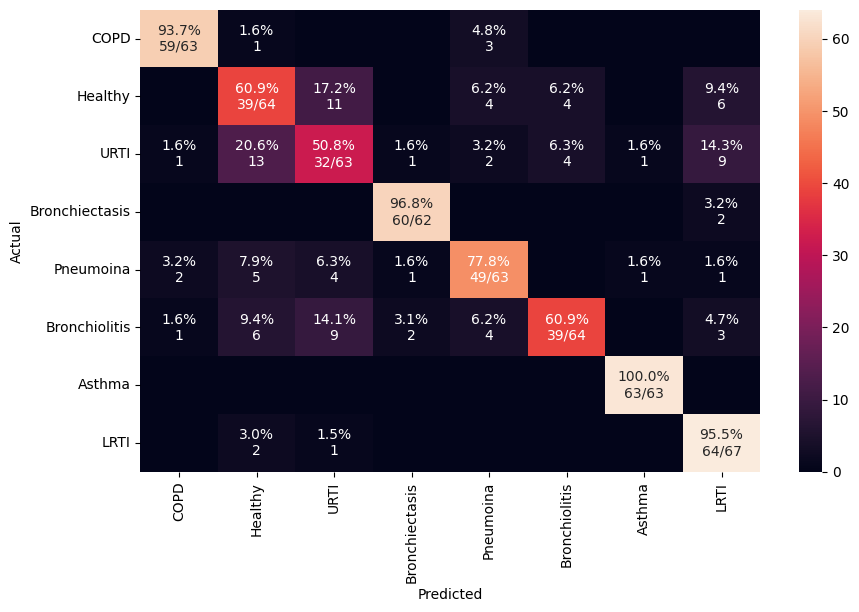

In [12]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
#matrix_index = ["COPD", "Healthy", "URTI", "Bronchiectasis", "Pneumoina", "Bronchiolitis"]
#Uncomment if lrti and asthma is not dropped
matrix_index = ["COPD", "Healthy", "URTI", "Bronchiectasis", "Pneumoina", "Bronchiolitis","Asthma","LRTI"]
preds = model.predict([X_mfcc_test, X_chroma_test])
classpreds = np.argmax(preds, axis=1) # predicted classes
y_testclass = np.argmax(y_test, axis=1) # true classes
cm = confusion_matrix(y_testclass, classpreds)
print(classification_report(y_testclass, classpreds, target_names=matrix_index))
# Get percentage value for each element of the matrix
cm_sum = np.sum(cm, axis=1, keepdims=True)
cm_perc = cm / cm_sum.astype(float) * 100
annot = np.empty_like(cm).astype(str)
nrows, ncols = cm.shape
for i in range(nrows):
    for j in range(ncols):
        c = cm[i, j]
        p = cm_perc[i, j]
        if i == j:
            s = cm_sum[i]
            annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
        elif c == 0:
            annot[i, j] = ''
        else:
            annot[i, j] = '%.1f%%\n%d' % (p, c)


# Display confusion matrix
df_cm = pd.DataFrame(cm, index = matrix_index, columns = matrix_index)
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
fig, ax = plt.subplots(figsize=(10,6))
sn.heatmap(df_cm, annot=annot, fmt='')

# Performance metrics
accuracy = accuracy_score(y_testclass, classpreds)
precision = precision_score(y_testclass, classpreds, average='weighted', zero_division=1)
recall = recall_score(y_testclass, classpreds, average='weighted', zero_division=1)
f1 = f1_score(y_testclass, classpreds, average='weighted', zero_division=1)


# Print metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision (Weighted): {precision:.4f}")
print(f"Recall (Weighted): {recall:.4f}")
print(f"F1 Score (Weighted): {f1:.4f}")

In [13]:
def evaluate_model_on_val(model, X_mfcc_val, X_chroma_val, y_val, class_labels):
    # Evaluate the model on the validation data (gets loss and accuracy)
    val_loss, val_accuracy = model.evaluate([X_mfcc_val, X_chroma_val], y_val, batch_size=32)

    # Print the overall validation performance (loss and accuracy)
    print(f"\nValidation Loss: {val_loss:.4f}")
    print(f"Validation Accuracy: {val_accuracy:.4f}")

    # Predict on validation data
    preds = model.predict([X_mfcc_val, X_chroma_val])
    class_preds = np.argmax(preds, axis=1)
    true_classes = np.argmax(y_val, axis=1)

    # Print classification report
    print("\nValidation Set Classification Report:")
    print(classification_report(true_classes, class_preds, target_names=class_labels))

    # Generate confusion matrix
    cm = confusion_matrix(true_classes, class_preds)
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100

    # Create annotated matrix
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)

    # Display confusion matrix
    df_cm = pd.DataFrame(cm, index=class_labels, columns=class_labels)
    df_cm.index.name = 'Actual'
    df_cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=(10, 6))
    sn.heatmap(df_cm, annot=annot, fmt='', cmap='Greens', ax=ax)
    plt.title("Validation Confusion Matrix")
    plt.show()

    # Performance metrics (optional additional metrics)
    accuracy = accuracy_score(true_classes, class_preds)
    precision = precision_score(true_classes, class_preds, average='weighted', zero_division=1)
    recall = recall_score(true_classes, class_preds, average='weighted', zero_division=1)
    f1 = f1_score(true_classes, class_preds, average='weighted', zero_division=1)

    # Print metrics
    print(f"Accuracy (Weighted): {accuracy:.4f}")
    print(f"Precision (Weighted): {precision:.4f}")
    print(f"Recall (Weighted): {recall:.4f}")
    print(f"F1 Score (Weighted): {f1:.4f}")

29/29 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - accuracy: 0.8144 - loss: 0.5491

Validation Loss: 0.5834
Validation Accuracy: 0.8024
29/29 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step

Validation Set Classification Report:
                precision    recall  f1-score   support

          COPD       0.92      0.97      0.95       112
       Healthy       0.60      0.64      0.62       116
          URTI       0.55      0.54      0.55       113
Bronchiectasis       0.93      0.96      0.95       112
     Pneumoina       0.78      0.78      0.78       113
 Bronchiolitis       0.87      0.60      0.71       115
        Asthma       1.00      1.00      1.00       114
          LRTI       0.78      0.93      0.85       121

      accuracy                           0.80       916
     macro avg       0.81      0.80      0.80       916
  weighted avg       0.81      0.80      0.80       916



C:\Users\INSTRUCT-D522lab\AppData\Local\Temp\ipykernel_9836\115946394.py:32: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)


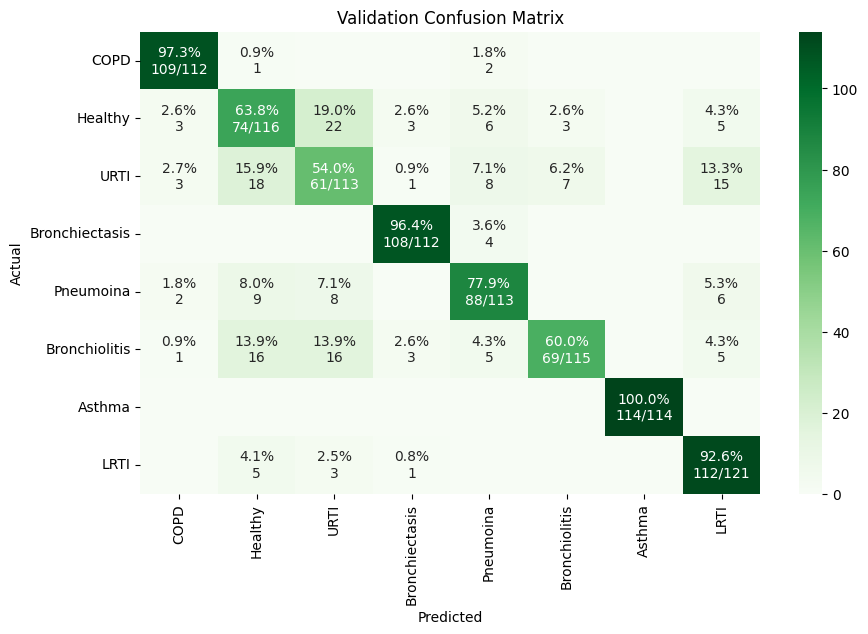

Accuracy (Weighted): 0.8024
Precision (Weighted): 0.8050
Recall (Weighted): 0.8024
F1 Score (Weighted): 0.7995


In [14]:
#Uncomment if lrti and asthma is not dropped
matrix_index = ["COPD", "Healthy", "URTI", "Bronchiectasis", "Pneumoina", "Bronchiolitis","Asthma","LRTI"]
#matrix_index = ["COPD", "Healthy", "URTI", "Bronchiectasis", "Pneumoina", "Bronchiolitis"]
evaluate_model_on_val(model, X_mfcc_val, X_chroma_val, y_val, matrix_index)

In [15]:
model.save('version-4A.keras')